# Assignment 1 - Data Science in Python
<br>
<b>Name: Kunal J. Tolani<br>
Student ID: 19200153 <br></b>

### Imports

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
import requests
import scrapy
import seaborn as sns
import math

# 1. Data identification

OMDB API - An API for Movie details was chosen, provided by http://www.omdbapi.com/

This api takes  an IMDB ID, and returns all the details of the particular movie or tv show. I have used a scraper to get IMDB IDs of all movies from the last 5 years, specifically 2015-2019.

The API is free to use for a limited amount of calls a day, and required signing up to patreon to get 100,000 calls a day.

The API key is babe1439

In [2]:
api_key = "babe1439"

# 2. Data collection

### Scraping of IMDB for IDs.

I used scrapy to go through the list of IMDB movies, and scrape IDs from the page. These IDs are then passed one by one to the API and movie details are stored.

#### Warning
This takes a lot of time to run.

In [3]:
output = [] #Output list, storing IDs.
class ImDbScrape(scrapy.Spider): #create the Scraper
    name="links"
    allowed_domains=["imdb.com"] #Allowed domains for the scraper
    
    #URL to start scraping
    start_urls=["https://www.imdb.com/search/title/?title_type=feature,tv_movie&release_date=2015-01-01,2019-12-31&sort=alpha,asc"]
  
    def parse(self,response):
        global output

        output.extend(response.css("h3.lister-item-header a::attr(href)").extract()) #Retrieving and storing the link to the movie 
        nexturl = response.css('a.lister-page-next::attr(href)').extract_first() #Get the url for next page in pagination
        if nexturl:
            next_page = response.urljoin(nexturl)
            yield scrapy.Request(url=next_page, callback=self.parse) #making request for the next page if next page is available

from scrapy.crawler import CrawlerProcess

a = CrawlerProcess({
    'USER_AGENT': 'Mozilla/5.0',
    'FEED_FORMAT': 'csv',
    'FEED_URI': 'outputa.csv',
})
a.crawl(ImDbScrape)
a.start()  #Start crawler

links = [op.split('/')[2] for op in output] #Get IDs from link
text_file = open("IMDB_IDs.txt", "w") #Store IDs to txt file
text_file.write(",".join(links))
text_file.close()

In [4]:
# Getting ids from the stored file file
file = open(r"IMDB_IDs.txt", "r")
links = file.readline()
links = links.split(',')

In [5]:
# Number of ids in the file
len(links)

72272

In [6]:
links[:5]

['tt6963362', 'tt10985348', 'tt4470336', 'tt8393004', 'tt5255986']

### API Calls to get data

In [7]:
# Initializing lists for api calls
error_list = []
no_year_list = []
list_final = []

### Warning
This will take a few hours to run

In [8]:
def get_data():
    count = 0
    data_file = open("data.csv", "a") #Data.csv is created and data is appended to it
    for i in range(0,len(links)): #Go through all the links
        link = links[i]
        
        #Rotten tomato ratings and box office numbers might not always have keys, so initialize as N/A
        rottenTomatoes = "N/A" 
        boxOffice = "N/A"
        
        #URL for api calls
        url = "http://www.omdbapi.com/?i="+links[i]+"&apikey="+api_key
        response = requests.get(url)
        if response.status_code == 200: #Success
            try: #Enclose in try catch for any errors occuring, including Json decode errors
                
                #There are some cases even with the advanced search links that the actual year of release is before 2015, or after 2019. 
                #Only include data for years 2015-2019
                if 'Year' in response.json() and response.json()['Year'] in ['2015','2016','2017','2018','2019']:
                    d = response.json()
                    if d['Ratings']: #Check if ratings are present - Rotten Tomato Ratings are included in this
                        for rat in d['Ratings']:
                            if rat['Source'] == 'Rotten Tomatoes':
                                rottenTomatoes = rat['Value']
                    if d["BoxOffice"]: #Check is box office numbers are present
                        boxOffice = d["BoxOffice"]
                        
                    #Append to list and write to data file
                    list_final.append([d['imdbID'],d['Title'],d['Year'],d['Released'], d['Runtime'],d['Language'],d['Genre'],d['Rated'],d['imdbRating'],d['Metascore'], d['imdbVotes'], rottenTomatoes, boxOffice])
                    data_file.write(";".join([d['imdbID'],d['Title'],d['Year'],d['Released'], d['Runtime'],d['Language'],d['Genre'],d['Rated'],d['imdbRating'],d['Metascore'], d['imdbVotes'], rottenTomatoes, boxOffice])+"\n")

                else:
                    #If year is not in 2015-2019, links went into the no-year list. This could be for a couple of reasons. 
                    #Sometimes, a movie is simply not found by the api, but returns 200 with an error and is later found. This link was used to run the api call again for ids in the no_year_list.

                    no_year_list.append(link) 
            except: #Print out any exceptions, and add to error list
                e = sys.exc_info()[0]
                error_list.append(link)
                print("Error at link: " + str(link) + " ---- " + str(e))
                continue
        else:
            error_list.append(link)
        count+=1
    data_file.close()
    print(count) #Maintain count of runs

get_data() #Make the function call

In [10]:
#Display lengths of lists

display(len(list_final))
display(len(error_list))

73029

1085

In [11]:
#An example of what the data looks like

list_final[0]

['tt6963362',
 'The Wind Bloweth Where It Listeth',
 '2017',
 '28 Jan 2017',
 '100 min',
 'Swedish, English',
 'Drama',
 'N/A',
 '6.3',
 'N/A',
 '9',
 'N/A',
 'N/A']

In [12]:
#Saving the lists to a pickle file

output = open('final_list_2.pkl', 'wb')
pickle.dump(list_final, output)
output.close()

output = open('error_list_2.pkl', 'wb')
pickle.dump(error_list, output)
output.close()

output = open('no_year_list_2.pkl', 'wb')
pickle.dump(no_year_list, output)
output.close()

In [59]:
#Loading data from the pickle file - was done to avoid reruns of api. Could've been done using the CSV, but a pickle file is faster for loading data.
#Here, for future proofing, a copy of the pickle file made earlier is used to load data
#This is done to ensure any inadvertent write to the data or pickle file does not erase the entire set.

pkl_file = open('final_list_final.pkl', 'rb')
list_final = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('error_list_final.pkl', 'rb')
error_list = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('no_year_list_final.pkl', 'rb')
no_year_list = pickle.load(pkl_file)
pkl_file.close()

# 3. Data preparation and analysis

### Preprocessing of Data

In [60]:
# A dataframe is created using the above list and a list of columns passed.

columns_list = ['ID','Title','Year','Released','Runtime','Language','Genre','Rated','IMDBRating','MetaCriticRating', 'IMDBVotes', 'RottenTomatoRating', 'BoxOffice']
df_movies = pd.DataFrame(list_final, columns=columns_list)
df_movies.drop_duplicates(keep="first", inplace=True) # In case duplicates are present in the data, drop them.
df_movies = df_movies.set_index('ID') #ID of the movie is set to the index of the dataframe

In [61]:
df_movies #Viewing dataframe

,Title,Year,Released,Runtime,Language,Genre,Rated,IMDBRating,MetaCriticRating,IMDBVotes,RottenTomatoRating,BoxOffice
ID,,,,,,,,,,,,
tt6963362,The Wind Bloweth Where It Listeth,2017,28 Jan 2017,100 min,"Swedish, English",Drama,N/A,6.3,N/A,9,N/A,N/A
tt4470336,#50Fathers,2015,01 Jul 2015,132 min,English,Comedy,N/A,N/A,N/A,N/A,N/A,N/A
tt5255986,#66,2015,N/A,116 min,Indonesian,Action,N/A,N/A,N/A,N/A,N/A,N/A
tt6170868,#BKKY,2016,12 Oct 2017,75 min,Thai,Drama,N/A,7.4,N/A,23,N/A,N/A
tt6529880,#BeingThirteen: Inside the Secret World of Teens,2015,06 Oct 2015,N/A,English,N/A,N/A,N/A,N/A,N/A,N/A,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...
tt11110904,Þorsti,2019,25 Oct 2019,90 min,Icelandic,"Comedy, Horror",N/A,N/A,N/A,N/A,N/A,N/A
tt3823018,Sparrows,2015,18 Oct 2015,99 min,"English, Icelandic",Drama,N/A,6.8,N/A,"1,365",83%,N/A
tt7175600,âmes soeurs,2017,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A


In [15]:
df_movies.dtypes

Title                 object
Year                  object
Released              object
Runtime               object
Language              object
Genre                 object
Rated                 object
IMDBRating            object
MetaCriticRating      object
IMDBVotes             object
RottenTomatoRating    object
BoxOffice             object
dtype: object

As we can see, all data is of type objects. We preprocess data to get them into the right type, and handle missing values.

In [16]:
#First "N/A" is replaced by nan in the entire dataset

df_movies.replace("N/A", np.nan, inplace=True)

In [17]:
#Removing % from Rotten Tomato Ratings
df_movies["RottenTomatoRating"] = df_movies["RottenTomatoRating"].str.replace(r'%$', '')

In [18]:
#Removing ' min' from Runtime, converting N/A to nans, and converting to float
df_movies["Runtime"] = df_movies["Runtime"].str.replace(r'min$', '')
# df_movies["Runtime"].replace("N/A", np.nan, inplace=True)
df_movies["Runtime"] = df_movies["Runtime"].str.replace(",","").astype(float)

In [19]:
# df_movies["Year"] = pd.to_numeric(df_movies["Year"], errors='coerce')  
df_movies["Runtime"] = pd.to_numeric(df_movies["Runtime"]) #Convert runtime to numeric
df_movies["IMDBRating"] = pd.to_numeric(df_movies["IMDBRating"], errors='coerce') #Convert IMDBRating to numeric
df_movies["MetaCriticRating"] = pd.to_numeric(df_movies["MetaCriticRating"], errors='coerce') #Convert metacritic rating to numeric
df_movies["RottenTomatoRating"] = pd.to_numeric(df_movies["RottenTomatoRating"], errors='coerce') #Convert rotten tomato rating to numeric
df_movies["Released"] = pd.to_datetime(df_movies["Released"], errors='coerce') #Convert Release date to datetime

In [20]:
#The comma is removed, and IMDBVotes are converted to float
# df_movies["IMDBVotes"].replace("N/A", np.nan, inplace=True)
df_movies["IMDBVotes"] = df_movies["IMDBVotes"].str.replace(",","").astype(float)

In [21]:
#The $ sign and commas are removed, and BoxOfffice figures are converted to float

df_movies["BoxOffice"] = df_movies["BoxOffice"].str.replace(r'^\$', '')
# df_movies["BoxOffice"].replace("N/A", np.nan, inplace=True)
df_movies["BoxOffice"] = df_movies["BoxOffice"].str.replace(",","").astype(float)

In [22]:
# To simplify things, only the first value of language and genres is kept.
# For movies of multiple languages and genres, the first one is the primary.

df_movies["Language"] = df_movies["Language"].str.split(",").str.get(0)
df_movies["Genre"] = df_movies["Genre"].str.split(",").str.get(0)

In [23]:
df_movies

,Title,Year,Released,Runtime,Language,Genre,Rated,IMDBRating,MetaCriticRating,IMDBVotes,RottenTomatoRating,BoxOffice
ID,,,,,,,,,,,,
tt6963362,The Wind Bloweth Where It Listeth,2017,2017-01-28,100.0,Swedish,Drama,NaN,6.3,NaN,9.0,NaN,NaN
tt4470336,#50Fathers,2015,2015-07-01,132.0,English,Comedy,NaN,NaN,NaN,NaN,NaN,NaN
tt5255986,#66,2015,NaT,116.0,Indonesian,Action,NaN,NaN,NaN,NaN,NaN,NaN
tt6170868,#BKKY,2016,2017-10-12,75.0,Thai,Drama,NaN,7.4,NaN,23.0,NaN,NaN
tt6529880,#BeingThirteen: Inside the Secret World of Teens,2015,2015-10-06,NaN,English,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
tt11110904,Þorsti,2019,2019-10-25,90.0,Icelandic,Comedy,NaN,NaN,NaN,NaN,NaN,NaN
tt3823018,Sparrows,2015,2015-10-18,99.0,English,Drama,NaN,6.8,NaN,1365.0,83.0,NaN
tt7175600,âmes soeurs,2017,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
df_movies.dtypes

Title                         object
Year                          object
Released              datetime64[ns]
Runtime                      float64
Language                      object
Genre                         object
Rated                         object
IMDBRating                   float64
MetaCriticRating             float64
IMDBVotes                    float64
RottenTomatoRating           float64
BoxOffice                    float64
dtype: object

The data has been converted to appropriate datatypes.

In [25]:
df_movies.describe()

,Runtime,IMDBRating,MetaCriticRating,IMDBVotes,RottenTomatoRating,BoxOffice
count,43123.000000,28946.000000,2950.000000,28944.000000,4046.000000,9.750000e+02
mean,92.620040,6.063356,56.391186,3925.849537,61.437222,3.166289e+07
std,291.434098,1.481430,17.368003,28070.653007,28.923041,8.060791e+07
min,1.000000,1.000000,3.000000,5.000000,0.000000,1.450000e+02
25%,78.000000,5.200000,44.000000,20.000000,39.000000,1.136025e+05
50%,90.000000,6.200000,58.000000,99.000000,67.000000,1.659463e+06
75%,105.000000,7.100000,69.000000,513.000000,86.000000,2.685428e+07
max,59460.000000,10.000000,99.000000,860709.000000,100.000000,9.366586e+08


It seems there are a few outliers present, specifically in the Runtime and IMDB votes columns. We'll have a look at these.

In [26]:
#Top 10 runtimes

df_movies[df_movies['Runtime'].notna()]['Runtime'].sort_values(ascending=False)[:10]

ID
tt10844584    59460.0
tt5136218      5460.0
tt5240738      4980.0
tt7538778      4320.0
tt5047248      3240.0
tt7321476      2160.0
tt7467634      1834.0
tt5942280      1559.0
tt6127010      1440.0
tt6532380      1440.0
Name: Runtime, dtype: float64

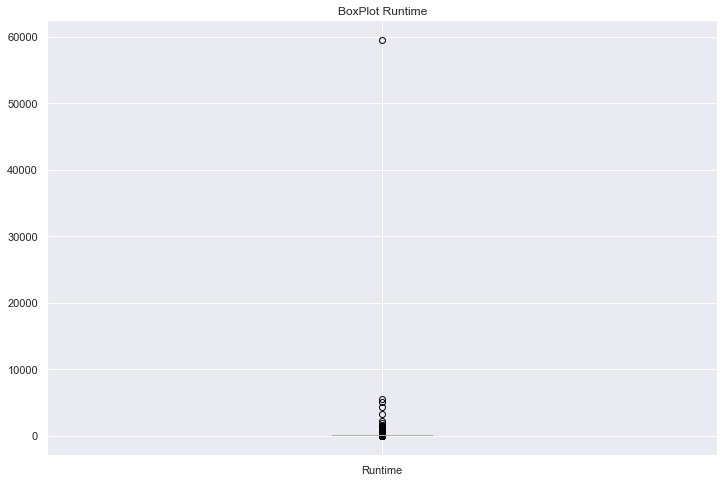

In [27]:
#Using boxplot for outliers
sns.set()

plt.figure(figsize=(12, 8))
plt.title("BoxPlot Runtime")
display(df_movies.boxplot(column=['Runtime']))

In [28]:
#Looking at the details of the movie with the highest runtime
df_movies.loc['tt10844584']

Title                                 100
Year                                 2019
Released              2019-08-22 00:00:00
Runtime                             59460
Language                          English
Genre                               Drama
Rated                                 NaN
IMDBRating                            9.2
MetaCriticRating                      NaN
IMDBVotes                               6
RottenTomatoRating                    NaN
BoxOffice                             NaN
Name: tt10844584, dtype: object

There certainly are outliers in the runtime column - We checked the movie. While it might be useful for analysis of ratings, it is not in runtime - so the runtime of the movie is set to NaN.

In [29]:
#Similarly for IMDB votes
df_movies[df_movies['IMDBVotes'].notna()]['IMDBVotes'].sort_values(ascending=False)[:10]

ID
tt1431045    860709.0
tt2488496    829363.0
tt1392190    821773.0
tt4154756    754875.0
tt3659388    717798.0
tt7286456    709240.0
tt2395427    700903.0
tt4154796    678181.0
tt1663202    662142.0
tt3498820    623003.0
Name: IMDBVotes, dtype: float64

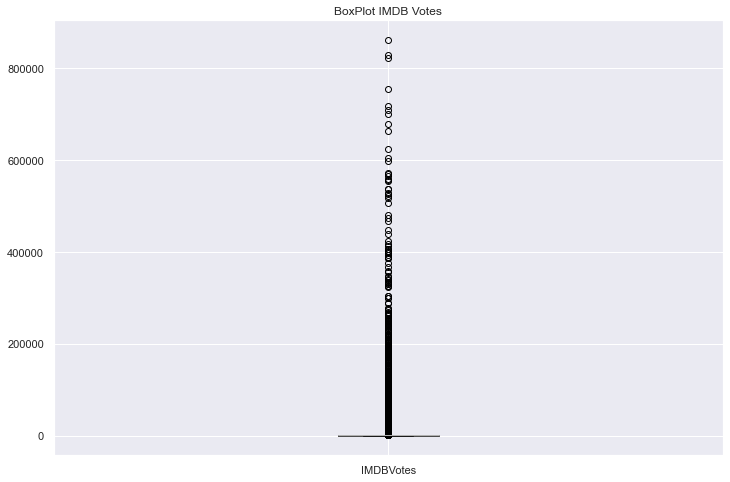

In [30]:
#Using boxplot to identify outliers
plt.figure(figsize=(12, 8))

plt.title("BoxPlot IMDB Votes")
df_movies.boxplot(column=['IMDBVotes'])

For IMDB Votes, it does not seem to be an outlier because there are a lot of values greater than 100000. This is probably due to a lot of movies not being votes on, and a lot of other being hugely popular. We won't make many changes here right now.

In [31]:
df_movies.loc['tt10844584','Runtime'] = np.nan #Replacing runtime of outlier with Nan

In [32]:
#Top 10 runtimes
df_movies[df_movies['Runtime'].notna()]['Runtime'].sort_values(ascending=False)[:10]

ID
tt5136218    5460.0
tt5240738    4980.0
tt7538778    4320.0
tt5047248    3240.0
tt7321476    2160.0
tt7467634    1834.0
tt5942280    1559.0
tt6127010    1440.0
tt8539844    1440.0
tt6532380    1440.0
Name: Runtime, dtype: float64

In [33]:
#Checking number of nans

df_movies.isnull().sum()

Title                     0
Year                      0
Released              11693
Runtime               20150
Language               3667
Genre                 10214
Rated                 54712
IMDBRating            34326
MetaCriticRating      60322
IMDBVotes             34328
RottenTomatoRating    59226
BoxOffice             62297
dtype: int64

As we can see, there are a large number of null or missing values. For initial data analysis including year and language distributions, this will be kept as it is - only values that are not null will be used. For further analysis with multiple columns, data is imputed - at least for runtime and IMDB votes.

In [34]:
# We check if there are rows almost entirely consisting of NaNs and NaTs - any row with more than 7 NaNs will be dropped as they are not useful for analysis other than basic counts.

df_movies[df_movies.loc[:,['Released','Runtime','Language','Genre','Rated','IMDBRating','MetaCriticRating','IMDBVotes','RottenTomatoRating']].isna().sum(axis=1).sort_values(ascending=False)>7]

/home/kunal/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,Title,Year,Released,Runtime,Language,Genre,Rated,IMDBRating,MetaCriticRating,IMDBVotes,RottenTomatoRating,BoxOffice
ID,,,,,,,,,,,,
tt6170650,#NeverTalkBackToAGangster,2016,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tt6046566,#humbled,2016,NaT,76.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tt6742214,#suziopaten,2017,NaT,NaN,English,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tt6871174,#truehomies,2018,NaT,NaN,English,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tt7923644,(A)social: 10 giorni senza lo smartphone,2018,2018-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
tt8824910,Ölümü gör,2018,NaT,NaN,Turkish,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tt9581172,Öndög,2019,2019-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tt5065762,Últimos días en La Habana,2016,NaT,NaN,Spanish,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Some Analysis

#### How many movies are made each year?

Average number of movies in a year:


12654.4

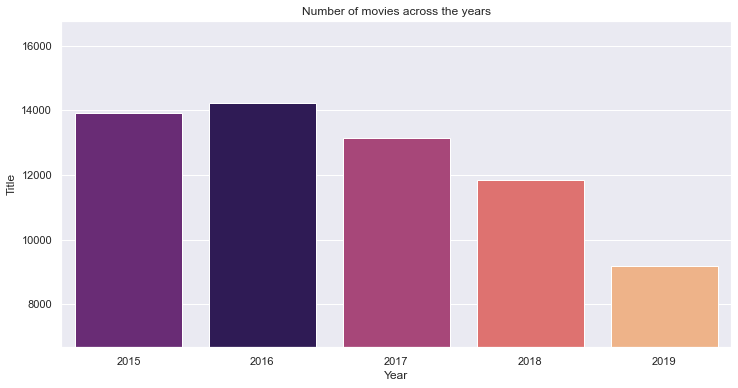

In [35]:
plt.figure(figsize=(12, 6))

plt.title("Number of movies across the years")
y_val = df_movies.groupby('Year')['Title'].nunique() #Grouping by years and getting count
l = min(y_val)
h = max(y_val)

plt.ylim([math.ceil(l-0.5*(h-l)), math.ceil(h+0.5*(h-l))])

pal = sns.color_palette("magma", len(y_val))
rank = y_val.argsort().argsort()

sns.barplot(y_val.index,y_val, palette=np.array(pal[::-1])[rank])

print("Average number of movies in a year:")
display(df_movies['Title'].count()/5)

On an average, 12654 movies are made each year. 2016 was the most productive year, followed by 2015 with around 14000 movies made. Only around 9000 movies were made in 2019 in contrast.

#### Which languages are the most common?

[Text(0, 0.5, 'Number of movies'), Text(0.5, 0, 'Year')]

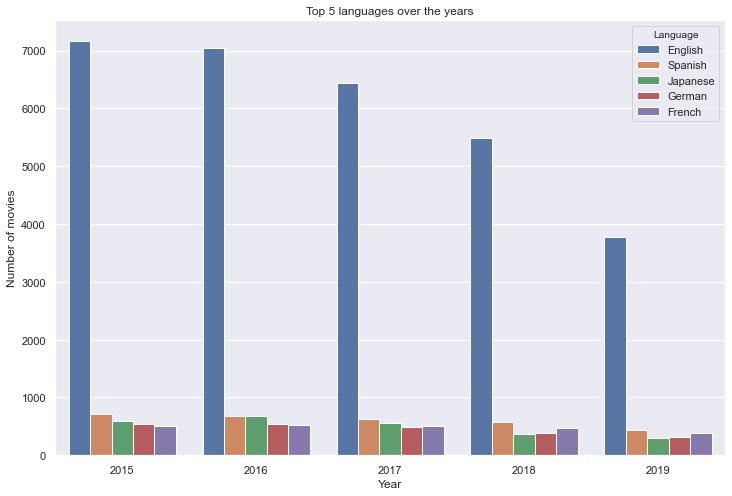

In [36]:
plt.figure(figsize=(12, 8))

#Getting the top 5 languages every year
lang_df = df_movies.groupby('Year')['Language'].value_counts().groupby(level=[0]).nlargest(5).reset_index(level=0, drop=True).unstack().sort_values(by='2015',axis=1, ascending=False)
lang_df = pd.melt(lang_df.reset_index(), id_vars=['Year'], value_vars=lang_df.columns)
plt.title("Top 5 languages over the years")
sns.barplot(data=lang_df, x="Year",y="value",hue="Language").set(xlabel="Year",ylabel="Number of movies")


The same languages take the top 5 spots every year - English, Spanish, Japanese, German, French - with English language movies being by far the most prominent.

#### What genres are more common?

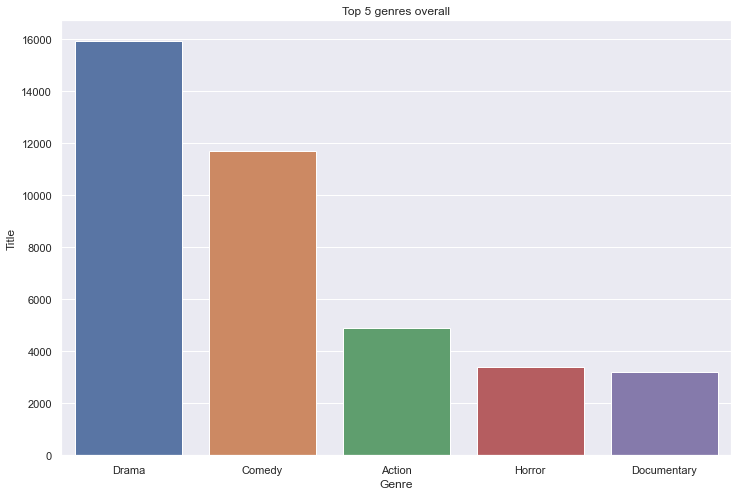

In [37]:
plt.figure(figsize=(12, 8))

plt.title("Top 5 genres overall")
y_val = df_movies.groupby('Genre')['Title'].nunique().sort_values(ascending=False)[:5]
sns.barplot(y_val.index,y_val)

[Text(0, 0.5, 'Number of Movies')]

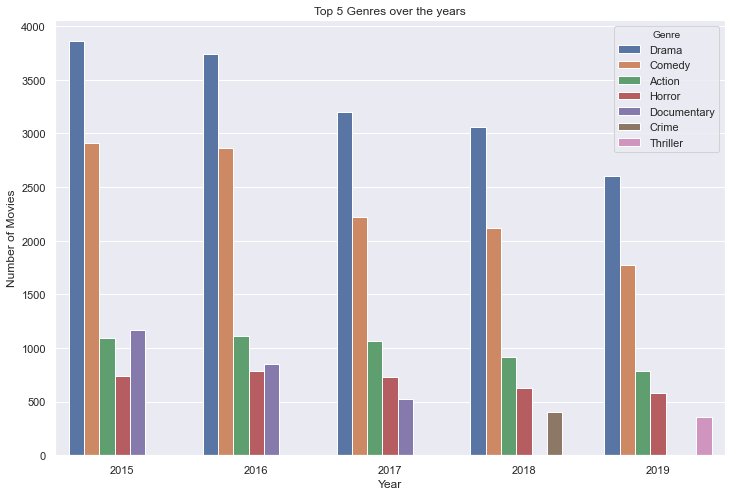

In [38]:
plt.figure(figsize=(12, 8))

#Getting the top 5 genres every year
lang_df = df_movies.groupby('Year')['Genre'].value_counts().groupby(level=[0]).nlargest(5).reset_index(level=0, drop=True).unstack().sort_values(by='2017',axis=1, ascending=False)
lang_df = pd.melt(lang_df.reset_index(), id_vars=['Year'], value_vars=lang_df.columns)
plt.title("Top 5 Genres over the years")
sns.barplot(data=lang_df, x="Year",y="value",hue="Genre").set(ylabel="Number of Movies")

The genres of drama and comedy have seen the most movies released overall, and across each of the last 5 years. Since we selected only the top 5 movie genres for each year, the graph looks distorted. Documentaries were common between 2015-2017, but seem to have fallen out of the top 5 for Crime and Thriller movies.

#### What is the average runtime of movies across the years

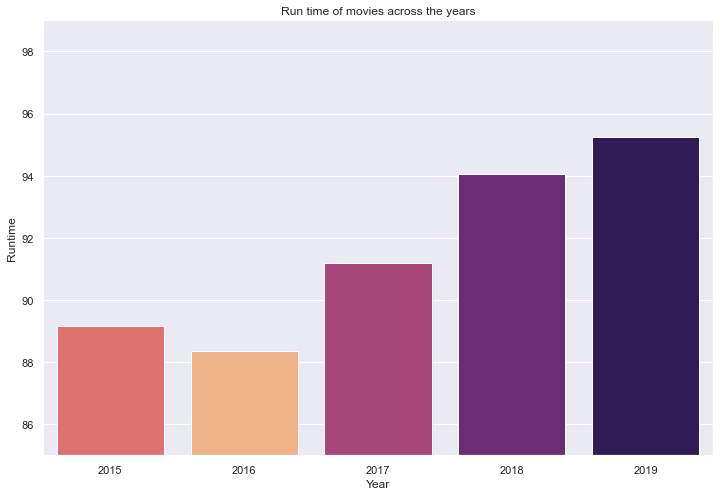

In [39]:
plt.figure(figsize=(12, 8))

plt.title("Run time of movies across the years")
y_val = df_movies.groupby('Year')['Runtime'].mean()
l = min(y_val)
h = max(y_val)
plt.ylim([math.ceil(l-0.5*(h-l)), math.ceil(h+0.5*(h-l))])

pal = sns.color_palette("magma", len(y_val))
rank = y_val.argsort().argsort()

sns.barplot(y_val.index,y_val, palette=np.array(pal[::-1])[rank])


2019 was the year of long movies, apparently. There were a lot of movies in 2016, but on average they were quite short.

##### From this point on, the above rows with more than 7 NaN columns are removed.

In [40]:
df_movies.drop(df_movies[df_movies.loc[:,['Released','Runtime','Language','Genre','Rated','IMDBRating','MetaCriticRating','IMDBVotes','RottenTomatoRating']].isna().sum(axis=1).sort_values(ascending=False)>7].index, inplace=True)

/home/kunal/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [41]:
df_movies

,Title,Year,Released,Runtime,Language,Genre,Rated,IMDBRating,MetaCriticRating,IMDBVotes,RottenTomatoRating,BoxOffice
ID,,,,,,,,,,,,
tt6963362,The Wind Bloweth Where It Listeth,2017,2017-01-28,100.0,Swedish,Drama,NaN,6.3,NaN,9.0,NaN,NaN
tt4470336,#50Fathers,2015,2015-07-01,132.0,English,Comedy,NaN,NaN,NaN,NaN,NaN,NaN
tt5255986,#66,2015,NaT,116.0,Indonesian,Action,NaN,NaN,NaN,NaN,NaN,NaN
tt6170868,#BKKY,2016,2017-10-12,75.0,Thai,Drama,NaN,7.4,NaN,23.0,NaN,NaN
tt6529880,#BeingThirteen: Inside the Secret World of Teens,2015,2015-10-06,NaN,English,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
tt8514766,Üç Harflilerin Musallat Oldugu Büyülü Konakta ...,2018,2018-10-05,80.0,Turkish,Comedy,NaN,4.6,NaN,29.0,NaN,NaN
tt11110904,Þorsti,2019,2019-10-25,90.0,Icelandic,Comedy,NaN,NaN,NaN,NaN,NaN,NaN
tt3823018,Sparrows,2015,2015-10-18,99.0,English,Drama,NaN,6.8,NaN,1365.0,83.0,NaN


#### What does the imdb rating distribution look like for all movies?

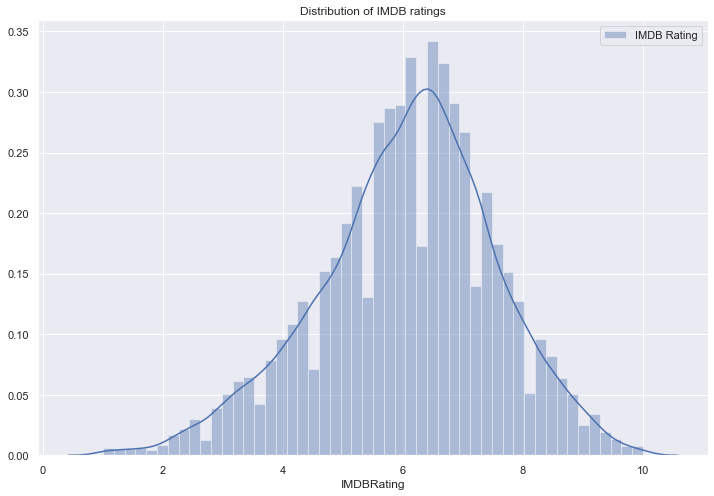

In [42]:
plt.figure(figsize=(12, 8))

plt.title("Distribution of IMDB ratings")
sns.distplot(df_movies['IMDBRating'], label="IMDB Rating")
plt.legend()

The distribution here is almost normal - just slightly skewed towards a higer rating. Surprisingly, only a few movies are rated exceptionally low, as compared to very high - this might point to users only rating movies they liked.

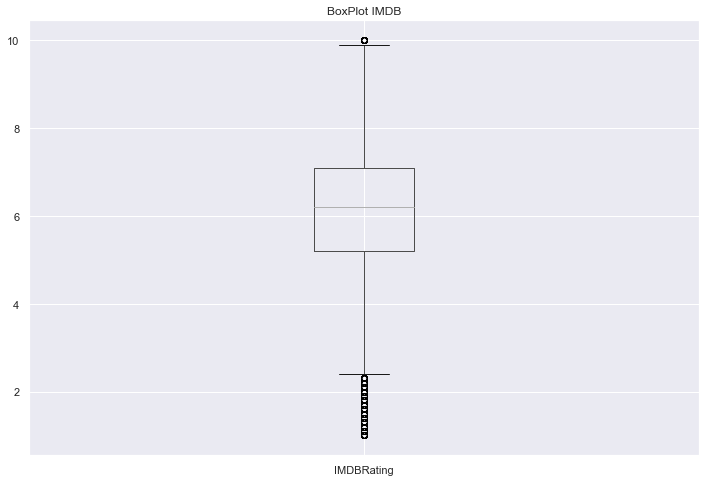

In [43]:
plt.figure(figsize=(12, 8))

plt.title("BoxPlot IMDB")
display(df_movies.boxplot(column=['IMDBRating']))

As expected, most of the movies hover around the above average mark - with rating between 6 to 8. A very few number of movies are either exceptionally bad or exceptionally good, but even then ratings below 2 are seen to be outliers in the plot - not common at all.

###### Similarly for MetaCritic and Rotten Tomato Ratings

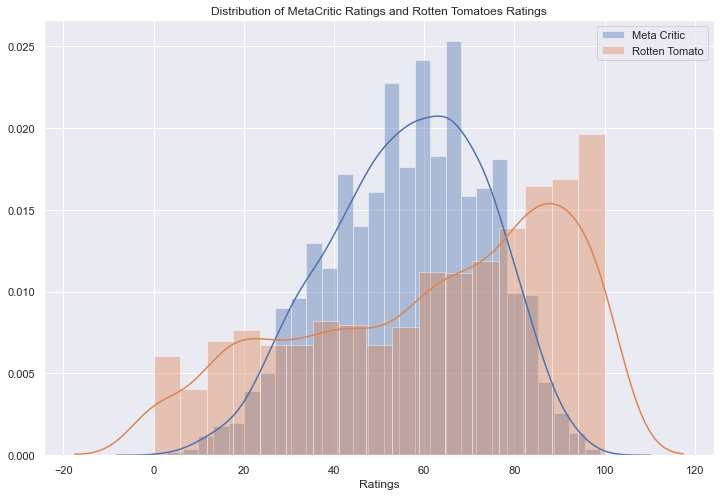

In [44]:
plt.figure(figsize=(12, 8))

plt.title("Distribution of MetaCritic Ratings and Rotten Tomatoes Ratings")
sns.distplot(df_movies['MetaCriticRating'], label="Meta Critic")
sns.distplot(df_movies['RottenTomatoRating'], label="Rotten Tomato")
plt.xlabel("Ratings")
plt.legend()

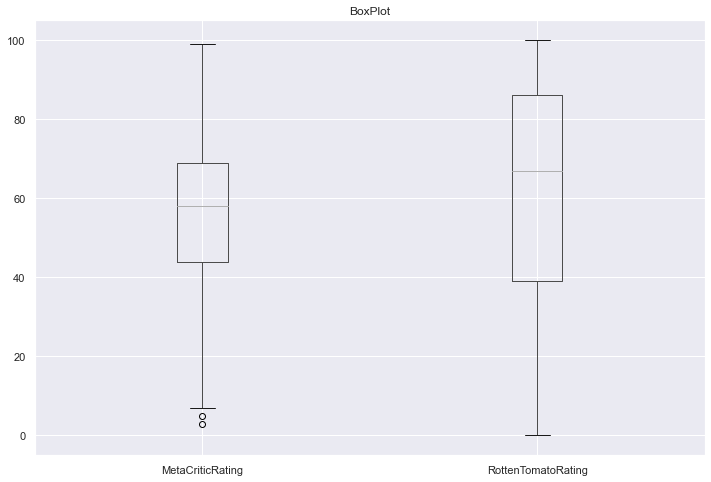

In [45]:
#Looking at the boxplots.
plt.figure(figsize=(12, 8))
plt.title("BoxPlot")
df_movies.boxplot(column=['MetaCriticRating','RottenTomatoRating'])

MetaCritic and Rotten Tomatoes both rate critics ratings, as compared to user ratings - however the distribution for both look different. This is because of the way aggregation of ratings of each website works.
While MetaScore calculates weighted average ratings from each critic reviewer, Rotten Tomatoes simply takes the ratio of how many critics rated the movie positively as opposed to negatively.

Instead, we'll look at what percentage of movies were rated positively across all three ratings systems. Positive rating is defined as >50 rating for MetaCritic and RottenTomatoes, and >5 for IMDB.

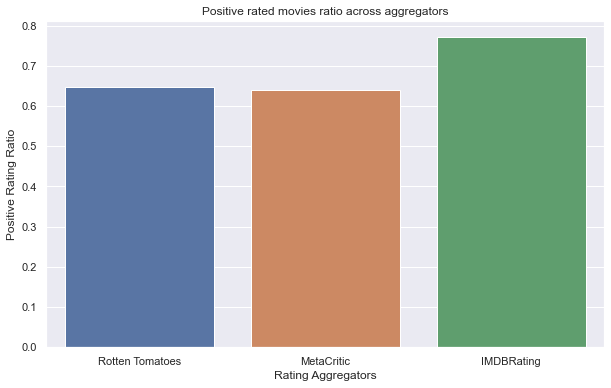

In [46]:
plt.figure(figsize=(10, 6))

positive_movies = {}
positive_movies['Rotten Tomatoes'] = df_movies[df_movies['RottenTomatoRating']>50]['Title'].count() / df_movies[df_movies['RottenTomatoRating'].notna()]['Title'].count()
positive_movies['MetaCritic'] = df_movies[df_movies['MetaCriticRating']>50]['Title'].count() / df_movies[df_movies['MetaCriticRating'].notna()]['Title'].count()
positive_movies['IMDBRating'] = df_movies[df_movies['IMDBRating']>5]['Title'].count() / df_movies[df_movies['IMDBRating'].notna()]['Title'].count()
plt.xlabel("Rating Aggregators")
plt.ylabel("Positive Rating Ratio")
plt.title("Positive rated movies ratio across aggregators")
sns.barplot(x=list(positive_movies.keys()), y=list(positive_movies.values()))

As can be seen, Rotten Tomatoes and MetaCritic both rate around 64% of movies positively - even if distributions differ, they both take into account critics reviews, so this makes sense.

IMDB ratings are much higher, in part due to there being more data, and because IMDB ratings are an average of user ratings - which can be different from critic ratings. A user may only rate the movies they liked, for example. 

##### Let's look at the correlation matrix

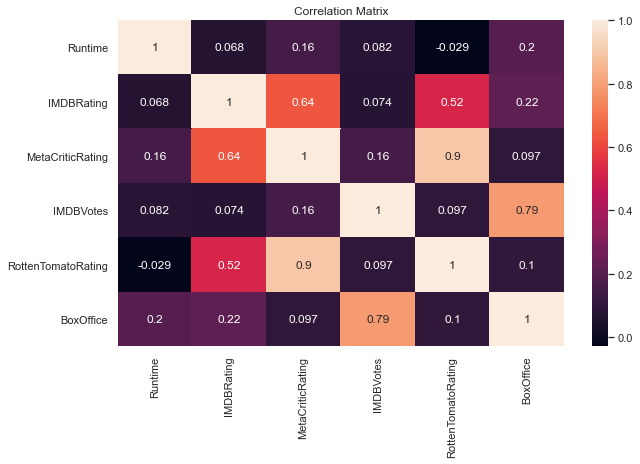

In [47]:
plt.figure(figsize=(10, 6))
plt.title("Correlation Matrix")

sns.heatmap(df_movies.corr(),annot=True)

There's a clear positive correlation between Box Office values and number of IMDB votes. Also, Rotten Tomato ratings and MetaCritic Ratings are highly positively correlated - some confirmation of the values seen in the positive movies graph. There is some correlation between IMDB and RottenTomato ratings, as well as MetaCritic and IMDB Ratings - again, user scores vs critic scores.

More importantly, there seems to be only slightly positive between box office numbers and IMDB ratings - a movie which earned high amounts of money doesn't necessarily mean it is liked. 

##### For rest of the analysis, we will drop the rows where all of IMDB, Rotten Tomatoes, and MetaCritic Ratings and IMDBVotes are null. 

In [48]:
df_movies_cleaned = df_movies.drop(df_movies[df_movies.loc[:,['IMDBRating','MetaCriticRating','IMDBVotes','RottenTomatoRating']].isna().sum(axis=1).sort_values(ascending=False)>3].index)

/home/kunal/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [49]:
#Checking number of nans

df_movies_cleaned.isnull().sum()

Title                     0
Year                      0
Released               1201
Runtime                3476
Language                820
Genre                  1411
Rated                 20993
IMDBRating              165
MetaCriticRating      26161
IMDBVotes               167
RottenTomatoRating    25066
BoxOffice             28138
dtype: int64

Let's plot how Box Office Numbers and IMDB votes are related using a regplot.

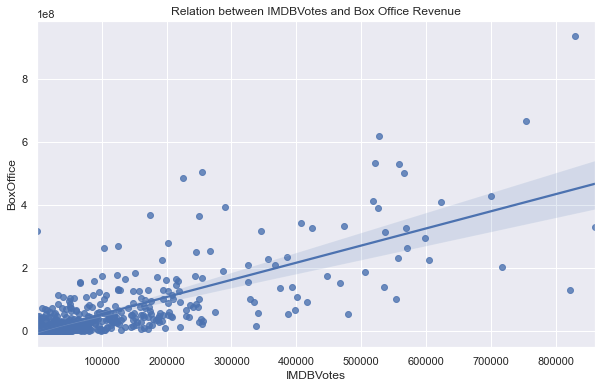

In [50]:
plt.figure(figsize=(10, 6))
plt.title("Relation between IMDBVotes and Box Office Revenue")
sns.regplot(data=df_movies_cleaned, x="IMDBVotes", y="BoxOffice")

There is a linear relation between the number of votes and box office numbers, as confirmed by the heatmap and the regplot.
<br><br>
Similarly, plotting for Meta critic and Rotten Tomato Ratings

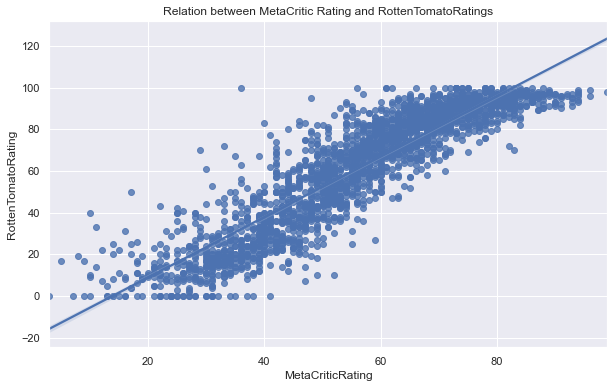

In [51]:
plt.figure(figsize=(10, 6))
plt.title("Relation between MetaCritic Rating and RottenTomatoRatings")
sns.regplot(data=df_movies_cleaned, x="MetaCriticRating", y="RottenTomatoRating")

Clear highly positive relation between the two rating systems, as was shown by the heatmap as well.

#### Some more plots

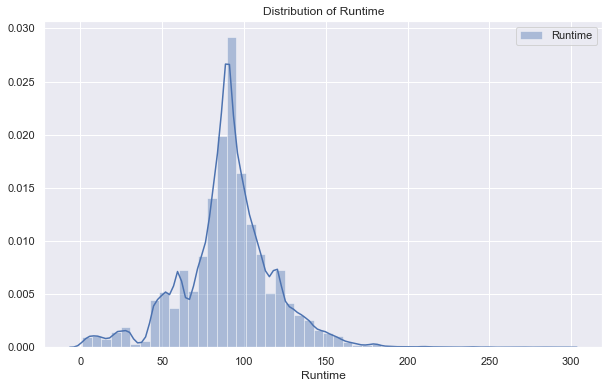

In [52]:
#Distribution of runtime
plt.figure(figsize=(10, 6))
plt.title("Distribution of Runtime")
sns.distplot(df_movies[df_movies['Runtime']<300]['Runtime'], label="Runtime")
plt.legend()

Most movies are around the 90 minutes runtime. A filter was kept to 300 minutes maximum, as there are a few movies with greater than a 1000 minutes of runtime.

####  Average runtime of movies - depending on the language and genre.

In [53]:
df_movies.groupby(['Genre']).Runtime.mean().nlargest(10)

Genre
Reality-TV    108.468750
Musical       107.006757
Action        104.180843
Biography     102.953461
Romance       101.699681
Mystery        98.719481
Drama          97.821417
Crime          95.712054
War            94.333333
Thriller       93.390678
Name: Runtime, dtype: float64

Reality TV Movies are long - which is interesting. The runtime of musicals is pretty high too, as opposed to, say, adventure. Including language in this would provide a better picture.

In [54]:
df_movies.groupby(['Genre','Language']).Runtime.mean().nlargest(10)

Genre        Language
Documentary  Bosnian     546.000000
Adventure    Tagalog     218.000000
Biography    Kazakh      207.000000
Musical      Tamil       190.000000
History      Kannada     185.000000
Comedy       Bhojpuri    183.000000
Action       Yoruba      180.000000
Biography    Tagalog     178.000000
Musical      Japanese    174.000000
Action       Italian     167.068966
Name: Runtime, dtype: float64

Bosnian documentaries are 546 minutes on average - this is because of a small number of documentaries (3), one of which ran for 1440 minutes. 
As can be seen, non English movies are usually longer than English movies:

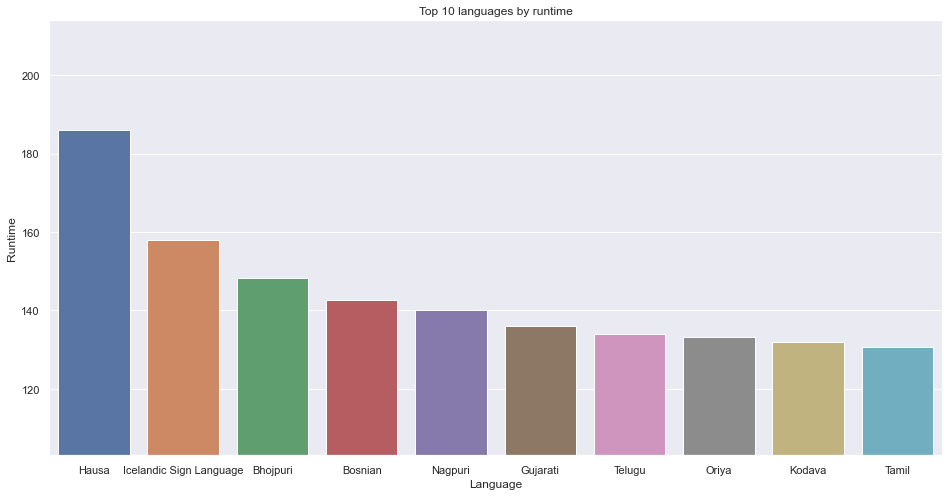

In [55]:
#Runtime based on language only

plt.figure(figsize=(16, 8))

plt.title("Top 10 languages by runtime")
y_val = df_movies.groupby('Language')['Runtime'].mean().sort_values(ascending=False)[:10]

l = min(y_val)
h = max(y_val)
plt.ylim([math.ceil(l-0.5*(h-l)), math.ceil(h+0.5*(h-l))])
sns.barplot(y_val.index,y_val)

In [56]:
#Runtime of English v Non English movies
print("Runtime English:")
display(df_movies[(df_movies['Language']=="English")]["Runtime"].mean())
print("Runtime Non-English:") 
display(df_movies[(df_movies['Language']!="English")]["Runtime"].mean())

Runtime English:


84.02345174163669

Runtime Non-English:


97.76254724444054

English movies are not on the list - which average around 84 minutes. Hausa language movies are the usually the longest, follwed by Icelandinc sign language and a range of Indian languages.

#### Let's check box office revenue

[Text(0, 0.5, 'Average Box Office Revenue in hundred millions (USD)')]

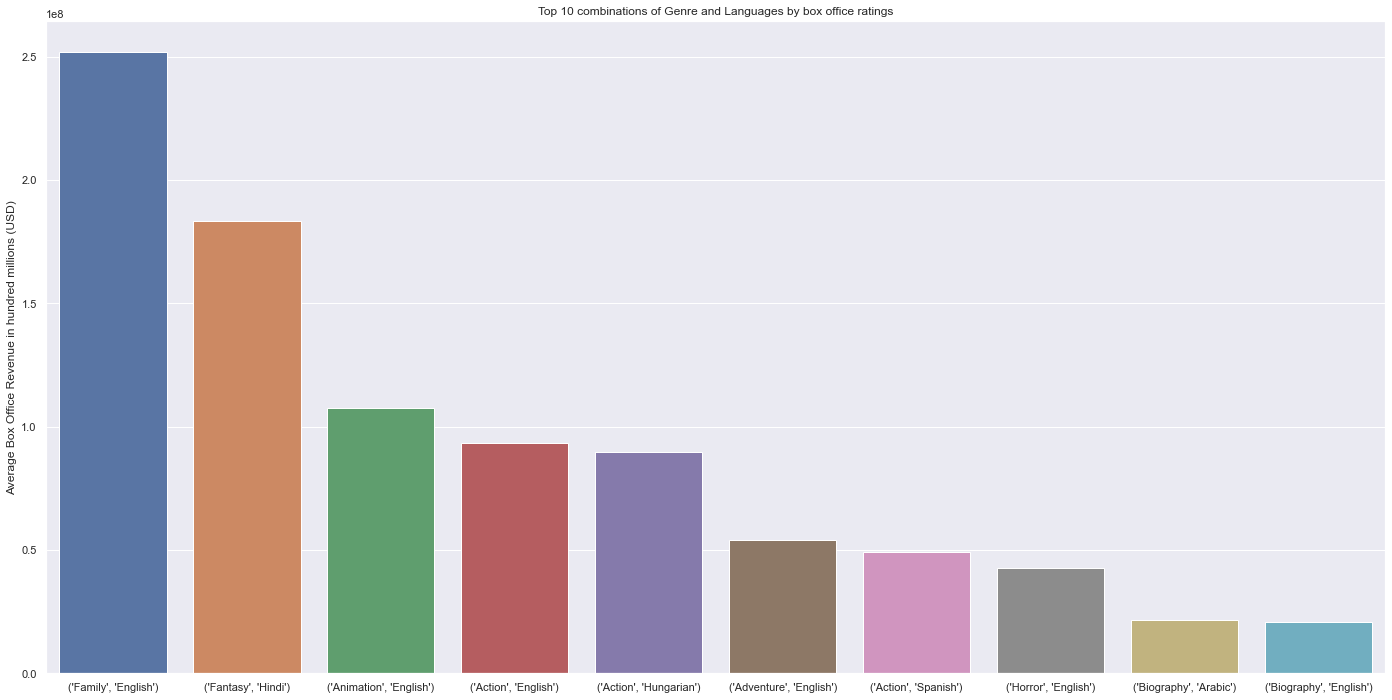

In [57]:
#Revenue according to genre and language

plt.figure(figsize=(24, 12))

plt.title("Top 10 combinations of Genre and Languages by box office ratings")
y_val = df_movies.groupby(['Genre','Language'])['BoxOffice'].mean().sort_values(ascending=False)[:10]

# l = min(y_val)
# h = max(y_val)
# plt.ylim([math.ceil(l-0.5*(h-l)), math.ceil(h+0.5*(h-l))])
sns.barplot(y_val.index,y_val).set(ylabel='Average Box Office Revenue in hundred millions (USD)')

Average revenue for English family movies are much higher than the second highest - Fantasy hindi movies. Action seems a common genre for big grossing movies across languages, as well as Biography.

English movies earn by far the highest revenue.

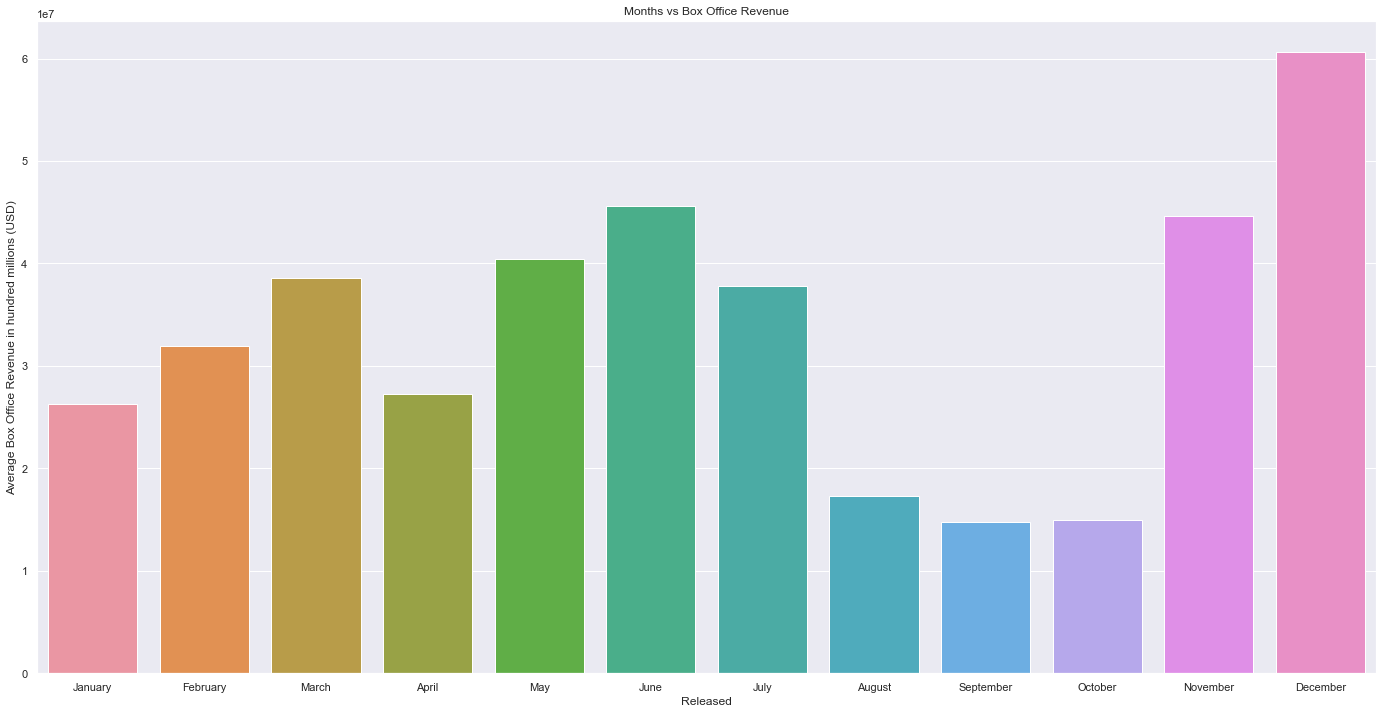

In [58]:
#Revenue according to release month

plt.figure(figsize=(24, 12))

plt.title("Months vs Box Office Revenue")
y_val = df_movies.groupby(df_movies.Released.dt.month)['BoxOffice'].mean()

mp = sns.barplot(y_val.index,y_val)
mp.set(ylabel='Average Box Office Revenue in hundred millions (USD)')
mp.set_xticklabels(['January','February','March','April','May','June','July','August','September','October','November','December'])
print()

It seems movies released in November and December, along with May, June and July are the most successful in terms of revenue. This is understandable as those are the holidays and summer months.

## Summary and conclusion

We used the omdb api to visualize and analyze movies released over the past 5 years. 

There were some interesting results, specifically the relation between ratings from Metacritic and Rotten Tomatoes, and how the number of IMDB votes and box office revenues relate.

A lot of data was unavailable, here it was handled by either removing the rows where too many nans were present, or ignoring nan values. Another way to handle this could've been to impute mean or frequent values, but I feel there was enough data present for an EDA, and wasn't done.

Some work that could be done would be looking more into the relations between categorical and numeric data, and how if the rating (pg, adult) of a movie affect revenues. Further analysis work would be to use predictions to determine how many more movies would come out over the year, and how successful and upcoming movie can be. More data would be required to do that, of course.